In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import traceback
import string
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
import xgboost
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn import metrics, svm
import seaborn as sns, numpy as np
import pandas.util.testing as tm
from datetime import datetime
import tensorflow as tf
from scipy.stats import pearsonr
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time

In [2]:
GlobalLandTemperaturesByCity = pd.read_csv('/Users/kreozotica/Desktop/Planetly/GlobalLandTemperaturesByCity.csv')
GlobalLandTemperaturesByCountry = pd.read_csv('/Users/kreozotica/Desktop/Planetly/GlobalLandTemperaturesByCountry.csv')


In [3]:
GlobalLandTemperaturesByCity.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
print(GlobalLandTemperaturesByCity.dt.min())
print(GlobalLandTemperaturesByCity.dt.max())

1743-11-01
2013-09-01


In [5]:
GlobalLandTemperaturesByCountry.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [6]:
print(GlobalLandTemperaturesByCountry.dt.min())
print(GlobalLandTemperaturesByCountry.dt.max())

1743-11-01
2013-09-01


In [7]:
#####################################
####### Data pre-processing ########
# number of missing values per DS
GlobalLandTemperaturesByCity.isnull().sum(axis = 0)

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [8]:
# number of missing values per DS
GlobalLandTemperaturesByCountry.isnull().sum(axis = 0)


dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [9]:
print('% of missing values for GlobalLandTemperaturesByCity dataset ', (GlobalLandTemperaturesByCity.isnull().sum(axis = 0).AverageTemperature)*100/len(GlobalLandTemperaturesByCity.AverageTemperature))

% of missing values for GlobalLandTemperaturesByCity dataset  4.234457761943768


In [10]:
print('% of missing values for GlobalLandTemperaturesByCountry dataset ', (GlobalLandTemperaturesByCountry.isnull().sum(axis = 0).AverageTemperature)*100/len(GlobalLandTemperaturesByCountry.AverageTemperature))

% of missing values for GlobalLandTemperaturesByCountry dataset  5.654224866744478


In [11]:
### checking the types of data 
GlobalLandTemperaturesByCity.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [12]:
### checking the types of data 
GlobalLandTemperaturesByCountry.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object

In [3]:
### transgorming dt column into DataTime format
GlobalLandTemperaturesByCity['dt'] = pd.to_datetime(GlobalLandTemperaturesByCity.dt, format='%Y-%m-%d')
GlobalLandTemperaturesByCountry['dt'] = pd.to_datetime(GlobalLandTemperaturesByCountry.dt, format='%Y-%m-%d')
print(GlobalLandTemperaturesByCity.dtypes)
print(GlobalLandTemperaturesByCountry.dtypes)

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object
dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
Country                                  object
dtype: object


In [4]:
GlobalLandTemperaturesByCountry['year'], GlobalLandTemperaturesByCountry['month'] = GlobalLandTemperaturesByCountry['dt'].dt.year, GlobalLandTemperaturesByCountry['dt'].dt.month
GlobalLandTemperaturesByCountry = GlobalLandTemperaturesByCountry.set_index(['dt']) 
Country = GlobalLandTemperaturesByCountry.copy()

In [5]:
GlobalLandTemperaturesByCity['year'], GlobalLandTemperaturesByCity['month'] = GlobalLandTemperaturesByCity['dt'].dt.year, GlobalLandTemperaturesByCity['dt'].dt.month
GlobalLandTemperaturesByCity = GlobalLandTemperaturesByCity.set_index(['dt']) 
City = GlobalLandTemperaturesByCity.copy()

In [6]:
def cutDF_forAveragingClimate(df, year_begin, year_end):
    df_cut = df.loc[str(year_begin):str(year_end)]
    df_cut = df_cut.dropna()
    df_cut = df_cut.set_index('year')

    return df_cut


In [7]:
Country_1900_2013 = cutDF_forAveragingClimate(Country, 1900, 2013)
City_1900_2013 = cutDF_forAveragingClimate(City, 1900, 2013)

In [8]:
AvgPerCountry1900_2013 = Country_1900_2013.groupby([Country_1900_2013.Country, Country_1900_2013.month]).mean().unstack()
Country_1743_1899 = Country.loc['1743':'1899']
Country_1743_1899

/Users/kreozotica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



,AverageTemperature,AverageTemperatureUncertainty,Country,year,month
dt,,,,,
1743-11-01,4.384,2.294,Åland,1743,11
1743-12-01,NaN,NaN,Åland,1743,12
1744-01-01,NaN,NaN,Åland,1744,1
1744-02-01,NaN,NaN,Åland,1744,2
1744-03-01,NaN,NaN,Åland,1744,3
...,...,...,...,...,...
1899-08-01,18.759,0.842,Zimbabwe,1899,8
1899-09-01,21.825,0.803,Zimbabwe,1899,9
1899-10-01,23.863,0.756,Zimbabwe,1899,10


In [9]:
AvgPerCity1900_2013 = City_1900_2013.groupby([City_1900_2013.Country, City_1900_2013.City, City_1900_2013.month]).mean().unstack()
AvgPerCity1900_2013 = AvgPerCity1900_2013.reset_index('City')
AvgPerCity1900_2013


City_1743_1899 = City.loc['1743':'1899']
City_1743_1899
 
 

/Users/kreozotica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
dt,,,,,,,,
1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743,11
1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,1743,12
1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744,1
1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744,2
1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744,3
...,...,...,...,...,...,...,...,...
1899-08-01,17.690,0.508,Zwolle,Netherlands,52.24N,5.26E,1899,8
1899-09-01,13.691,0.349,Zwolle,Netherlands,52.24N,5.26E,1899,9
1899-10-01,8.982,0.275,Zwolle,Netherlands,52.24N,5.26E,1899,10


In [10]:
def FillMean_DecadeAveraging_Countries(df_1743_1899, df_1900_2013, df_Avg_1900_2013 ):  ### itterating through the DF
    DecadeAvgd_full = []
    #df_ = pd.DataFrame(index=index, columns=columns)
    for Country_Name in df_1743_1899.Country.unique():
        df_1743_1899 = df_1743_1899[df_1743_1899.Country == Country_Name]
        
        Country_reshaped = df_1743_1899.pivot(index=['year', 'Country'], columns='month', values=['AverageTemperature', 'AverageTemperatureUncertainty'])
        Country_reshaped_filledNa = Country_reshaped.fillna(df_Avg_1900_2013)
        Country_reshaped_back1743_1899 = Country_reshaped_filledNa.stack()
        Country_reshaped_back1743_1899.reset_index(level=['Country', 'month'], inplace=True)

        df_1900_2013_country = df_1900_2013[df_1900_2013.Country == Country_Name]

        Data_Full_1743_2013 = pd.concat([Country_reshaped_back1743_1899 , df_1900_2013_country])
        Data_Full_1743_2013= Data_Full_1743_2013.reset_index()


        Data_Full_1743_2013['DateTime'] = Data_Full_1743_2013['year'].astype(str) + Data_Full_1743_2013['month'].astype(str).str.zfill(2)
        Data_Full_1743_2013['DateTime'] = pd.to_datetime(Data_Full_1743_2013['DateTime'], format='%Y%m')

        DecadeAvgd = Data_Full_1743_2013[['AverageTemperature','AverageTemperatureUncertainty']].groupby(Data_Full_1743_2013.DateTime.dt.year // 10).mean().reset_index()
        DecadeAvgd.DateTime = DecadeAvgd.DateTime *10
        DecadeAvgd['Country'] = Data_Full_1743_2013['Country'].loc[0]
            
        DecadeAvgd_full.append((DecadeAvgd)) 
        
    return DecadeAvgd_full 
 


In [11]:
DecadeAvgd_full = FillMean_DecadeAveraging_Countries(Country_1743_1899, Country_1900_2013, AvgPerCountry1900_2013)

In [12]:
Decadal_AVG = pd.concat(DecadeAvgd_full).sort_index().reset_index(drop=True)
Decadal_AVG.sort_values(by = ['Country', 'DateTime']).reset_index(drop=True)

,DateTime,AverageTemperature,AverageTemperatureUncertainty,Country
0,1900,13.718942,0.695733,Afghanistan
1,1910,13.819850,0.686367,Afghanistan
2,1920,13.706792,0.623733,Afghanistan
3,1930,13.691550,0.491867,Afghanistan
4,1940,14.386883,0.407475,Afghanistan
...,...,...,...,...
2867,1970,5.600417,0.417550,Åland
2868,1980,5.366067,0.414550,Åland
2869,1990,6.295967,0.408675,Åland
2870,2000,6.816300,0.347475,Åland


In [13]:
###### EDA:1 ########
def country_with_severe_temperature_change():
    Decadal_AVG_DecadaleChangePercent = []
    for Country_Name in Decadal_AVG.Country.unique():
        CountryDF = Decadal_AVG[Decadal_AVG.Country == Country_Name]

        DecadaleChangeInPercent = [] 
        fist_year = 0
        DecadaleChangeInPercent.append(fist_year)
        for i in range(1, len(CountryDF.AverageTemperature)):

            val = 100 - abs((CountryDF.AverageTemperature.iloc[i-1]*100)/CountryDF.AverageTemperature.iloc[i])
            DecadaleChangeInPercent.append(val)       

        CountryDF['DecadaleChangeInPercent'] = DecadaleChangeInPercent
        CountryDF['Country'] = Country_Name 

        Decadal_AVG_DecadaleChangePercent.append((CountryDF))


    Decadal_AVG_DecadaleChangePercent = pd.concat(Decadal_AVG_DecadaleChangePercent).sort_index().reset_index(drop=True)
    Decadal_AVG_DecadaleChangePercent.sort_values(by = ['Country', 'DecadaleChangeInPercent']).reset_index(drop=True)
    Decadal_AVG_DecadaleChangePercent = Decadal_AVG_DecadaleChangePercent.set_index('Country')
     
    return  Decadal_AVG_DecadaleChangePercent['DecadaleChangeInPercent'].idxmax(), Decadal_AVG_DecadaleChangePercent['DecadaleChangeInPercent'].idxmin()
#Decadal_AVG_DecadaleChangePercent['DecadaleChangeInPercent'].idxmax()

 

country_with_severe_temperature_change()
#Decadal_AVG 
#Decadal_AVG

/Users/kreozotica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/kreozotica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



('Norway', 'Norway')

In [ ]:
###### EDA:2 ########
### time variability in Temp per decade ####

In [14]:
def FillMean_DecadeAveraging_Cities(df_1743_1899, df_1900_2013, df_Avg_1900_2013 ):  ### itterating through the DF
    DecadeAvgd_City = []
    #df_ = pd.DataFrame(index=index, columns=columns)
    for City_Name in df_1900_2013.City.unique():
        df_1743_1899_City = df_1743_1899[df_1743_1899.City == City_Name]
        df_1743_1899_City = df_1743_1899_City[~df_1743_1899_City.duplicated(keep='first')]
        df_1743_1899_City = df_1743_1899_City[~df_1743_1899_City.index.duplicated(keep='first')]
    
        df_Avg_1900_2013_City = df_Avg_1900_2013[df_Avg_1900_2013.City == City_Name]
        
        df_1900_2013_City = df_1900_2013[df_1900_2013.City == City_Name]
        
        City_reshaped = df_1743_1899_City.pivot(index=['year', 'Country', 'City'], columns='month', values=['AverageTemperature', 'AverageTemperatureUncertainty'])
        City_reshaped_filledNa = City_reshaped.fillna(df_Avg_1900_2013_City)
        City_reshaped_back1743_1899 = City_reshaped_filledNa.stack()
        City_reshaped_back1743_1899.reset_index(level=['Country', 'City', 'month'], inplace=True)
        
          
        Data_Full_1743_2013_City = pd.concat([City_reshaped_back1743_1899 , df_1900_2013_City])
        Data_Full_1743_2013_City = Data_Full_1743_2013_City.reset_index()
     
    
    
        Data_Full_1743_2013_City['DateTime'] = Data_Full_1743_2013_City['year'].astype(str) + Data_Full_1743_2013_City['month'].astype(str).str.zfill(2)
        Data_Full_1743_2013_City['DateTime'] = pd.to_datetime(Data_Full_1743_2013_City['DateTime'], format='%Y%m')
        #### fill in Lat and Lon with non-empty vals
        Data_Full_1743_2013_City.fillna(method='bfill', inplace=True)
        
        DecadeAvgd = Data_Full_1743_2013_City[['AverageTemperature','AverageTemperatureUncertainty', 'Latitude', 'Longitude']].groupby(Data_Full_1743_2013_City.DateTime.dt.year // 10).mean().reset_index()
        DecadeAvgd.DateTime = DecadeAvgd.DateTime *10
        DecadeAvgd['City'] = Data_Full_1743_2013_City['City'].loc[0]
        DecadeAvgd['Country'] = Data_Full_1743_2013_City['Country'].loc[0]
        DecadeAvgd['Lat'] = Data_Full_1743_2013_City['Latitude'].loc[0]
        DecadeAvgd['Long'] = Data_Full_1743_2013_City['Longitude'].loc[0]
        
 
         
        #variability =  pd.DataFrame(DecadeAvgd.City.mean(),DecadeAvgd.Country.mean(), DecadeAvgd.Lat.mean(), DecadeAvgd.Long.mean(), )   
        var = DecadeAvgd.AverageTemperature.max() - DecadeAvgd.AverageTemperature.min()

        VariabilityDecade = pd.DataFrame(columns=['Variabiliy','City', 'Country', 'Lat', 'Long'])
        VariabilityDecade.loc['Variabiliy'] = pd.Series({'Variabiliy':var, 'City': DecadeAvgd.City.unique()[0], 'Country': DecadeAvgd.Country.unique()[0], 'Lat': DecadeAvgd.Lat.unique()[0], 'Long': DecadeAvgd.Long.unique()[0] })
         
        DecadeAvgd_City.append((VariabilityDecade))
        
    return DecadeAvgd_City 
        #return City_reshaped_back1743_1899
    
Vaariabiliy = FillMean_DecadeAveraging_Cities(City_1743_1899, City_1900_2013, AvgPerCity1900_2013)   

In [50]:
def highest_variability_temp_City(Cities_df, N):
    #Cities_df = FillMean_DecadeAveraging_Cities(City_1743_1899, City_1900_2013, AvgPerCity1900_2013)
 #   Cities_df = Variability.copy()
    
    Cities_Full_DF = pd.concat(Cities_df).sort_index().reset_index(drop=True)
    Cities_Full_DF = Cities_Full_DF.set_index('City')
    Cities_Full_DF = Cities_Full_DF.sort_values(by = ['Variabiliy'])

    return Cities_Full_DF.index[0:N] #Cities_Full_DF.index[:N]


highest_variability_temp_City(Vaariabiliy, 4)

Index(['Cairns', 'Ica', 'Townsville', 'Ayacucho'], dtype='object', name='City')

In [415]:
###### EDA:3 ########
### Plotting temperature developments over time ####
def Temp_data_top4eintries(df_1743_1899, df_1900_2013, df_Avg_1900_2013 ): 
    
    full_data = []
    averaged_decadal_data = []
    TopN_entires_City = highest_variability_temp_City(Vaariabiliy, 4)
    for i in TopN_entires_City:
        

        df_1743_1899_City = df_1743_1899[df_1743_1899.City == i]
        df_Avg_1900_2013_City = df_Avg_1900_2013[df_Avg_1900_2013.City == i]
        df_1900_2013_City = df_1900_2013[df_1900_2013.City == i]

        City_reshaped = df_1743_1899_City.pivot(index=['year', 'Country', 'City'], columns='month', values=['AverageTemperature', 'AverageTemperatureUncertainty'])
        City_reshaped_filledNa = City_reshaped.fillna(df_Avg_1900_2013_City)
        City_reshaped_back1743_1899 = City_reshaped_filledNa.stack()
        City_reshaped_back1743_1899.reset_index(level=['Country', 'City', 'month'], inplace=True)


        Data_Full_1743_2013_City = pd.concat([City_reshaped_back1743_1899 , df_1900_2013_City])
        Data_Full_1743_2013_City = Data_Full_1743_2013_City.reset_index()

        Data_Full_1743_2013_City['DateTime'] = Data_Full_1743_2013_City['year'].astype(str) + Data_Full_1743_2013_City['month'].astype(str).str.zfill(2)
        Data_Full_1743_2013_City['DateTime'] = pd.to_datetime(Data_Full_1743_2013_City['DateTime'], format='%Y%m')
        #### fill in Lat and Lon with non-empty vals
        Data_Full_1743_2013_City.fillna(method='bfill', inplace=True)

        DecadeAvgd = Data_Full_1743_2013_City[['AverageTemperature','AverageTemperatureUncertainty', 'Latitude', 'Longitude']].groupby(Data_Full_1743_2013_City.DateTime.dt.year // 10).mean().reset_index()
        DecadeAvgd.DateTime = DecadeAvgd.DateTime *10
        DecadeAvgd['City'] = Data_Full_1743_2013_City['City'].loc[0]
        DecadeAvgd['Country'] = Data_Full_1743_2013_City['Country'].loc[0]
        
        full_data.append(Data_Full_1743_2013_City)
        averaged_decadal_data.append(DecadeAvgd)
        
        
         
    return full_data, averaged_decadal_data

            
FullData,AveragedDecadal = Temp_data_top4eintries(City_1743_1899, City_1900_2013, AvgPerCity1900_2013)
 


In [188]:
AveragedDecadal_DF = pd.concat(AveragedDecadal).sort_index().reset_index(drop=True)
AveragedDecadal_DF.sort_values(by = ['Country', 'City', 'DateTime']).reset_index(drop=True)   
FullData_DF = pd.concat(FullData).sort_index().reset_index(drop=True)
FullData_DF.sort_values(by = ['Country', 'City', 'year']).reset_index(drop=True) 
FullData_DF

,year,Country,City,month,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,DateTime
0,1857,Australia,Cairns,1,25.926096,0.373807,16.87S,145.67E,1857-01-01
1,1855,Peru,Ica,1,12.444333,0.690526,13.66S,75.14W,1855-01-01
2,1855,Peru,Ayacucho,1,11.202421,0.655386,13.66S,73.49W,1855-01-01
3,1857,Australia,Townsville,1,26.645316,0.362465,18.48S,147.04E,1857-01-01
4,1855,Peru,Ica,2,12.702939,0.760763,13.66S,75.14W,1855-02-01
...,...,...,...,...,...,...,...,...,...
7563,2013,Peru,Ica,6,8.513000,1.333000,13.66S,75.14W,2013-06-01
7564,2013,Peru,Ayacucho,7,8.976000,1.203000,13.66S,73.49W,2013-07-01
7565,2013,Peru,Ica,7,7.672000,1.332000,13.66S,75.14W,2013-07-01
7566,2013,Peru,Ica,8,8.705000,0.845000,13.66S,75.14W,2013-08-01


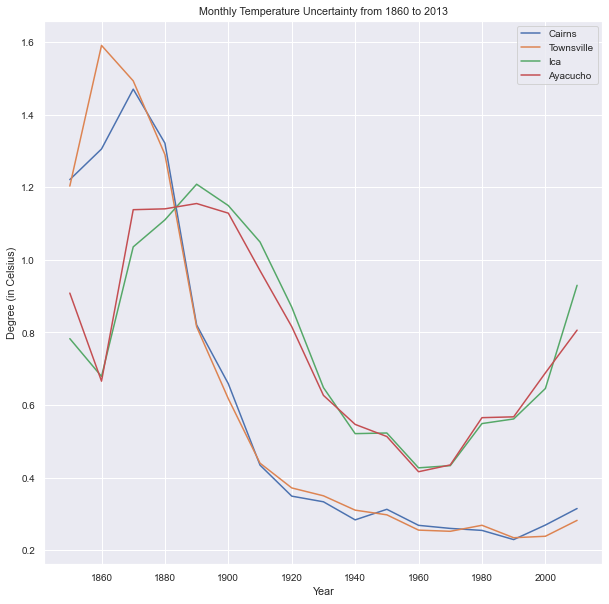

In [192]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
for city in AveragedDecadal_DF.City.unique():
     
    AveragedDecadal_DF_City = AveragedDecadal_DF[AveragedDecadal_DF.City == city]
    AveragedDecadal_DF_City

    plt.rcParams.update({'figure.figsize': (10,10)})
    plt.plot(AveragedDecadal_DF_City.DateTime, AveragedDecadal_DF_City.AverageTemperatureUncertainty, label = city)
    plt.legend(AveragedDecadal_DF_City.City.unique())
 
     
plt.gca().set(title="Monthly Temperature Uncertainty from 1860 to 2013", xlabel='Year', ylabel="Degree (in Celsius)")
plt.legend()


#plt.savefig('MonthlyPrecipitationUncertainty.png', format='png', dpi=300)

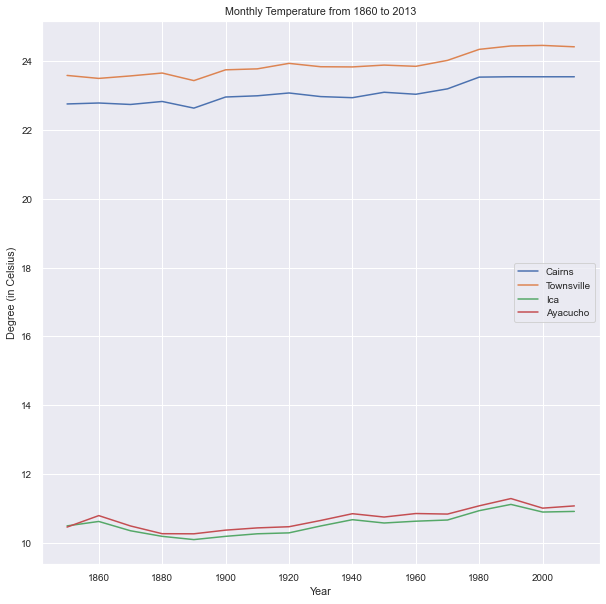

In [179]:
for city in AveragedDecadal_DF.City.unique():
     
    AveragedDecadal_DF_City = AveragedDecadal_DF[AveragedDecadal_DF.City == city]
    AveragedDecadal_DF_City

    plt.rcParams.update({'figure.figsize': (10,10)})
    plt.plot(AveragedDecadal_DF_City.DateTime, AveragedDecadal_DF_City.AverageTemperature, label = city)
    plt.legend(AveragedDecadal_DF_City.City.unique())
 
     
plt.gca().set(title="Monthly Temperature from 1860 to 2013", xlabel='Year', ylabel="Degree (in Celsius)")
plt.legend()

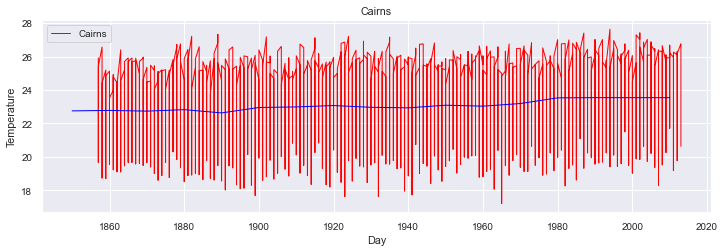

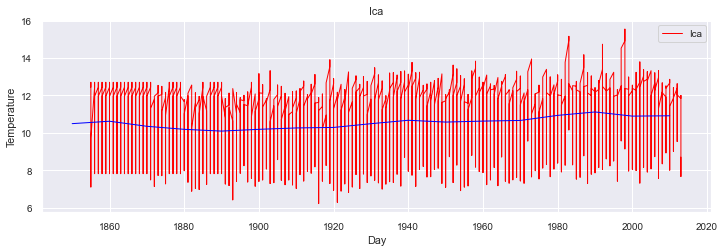

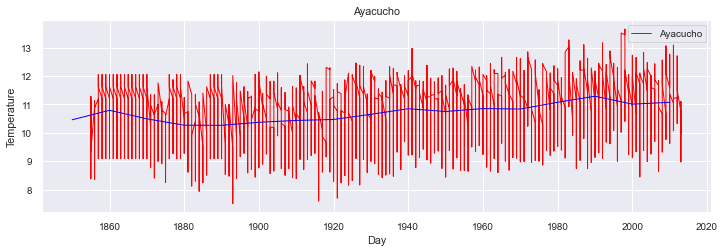

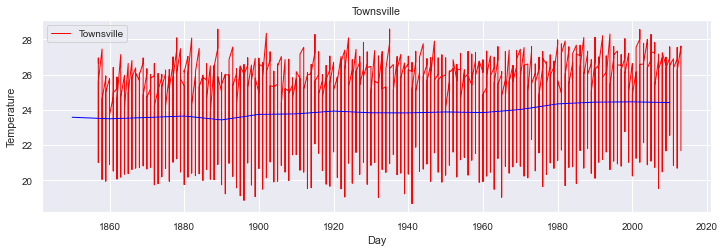

In [378]:
def plotting_TS_Averaged_temp(df_fullData, df_AVG_data):
    for city in df_fullData.City.unique():


        df_fullData_City = df_fullData[df_fullData.City == city]
        df_AVG_data_City = df_AVG_data[df_AVG_data.City == city]
        
        plt.figure(figsize=(12,12))

        plt.subplot(3, 1, 1)
        plt.plot(df_fullData_City['year'], df_fullData_City['AverageTemperature'], color = 'red', linewidth=1, label = 'True value')
        plt.plot(df_AVG_data_City['DateTime'], df_AVG_data_City['AverageTemperature'], color = 'blue', linewidth=1, label = 'Averaged value')

                
        plt.ylabel("Temperature")
        plt.xlabel("Day")
        plt.title(city)


        plt.rcParams.update({'figure.figsize': (10,10)})
        #plt.plot(df_AVG_data_City.DateTime, AveragedDecadal_DF_City.AverageTemperature, label = city)
        plt.legend(df_AVG_data_City.City.unique())
 
        

        

        
    return  

plotting_TS_Averaged_temp(FullData_DF, AveragedDecadal_DF)

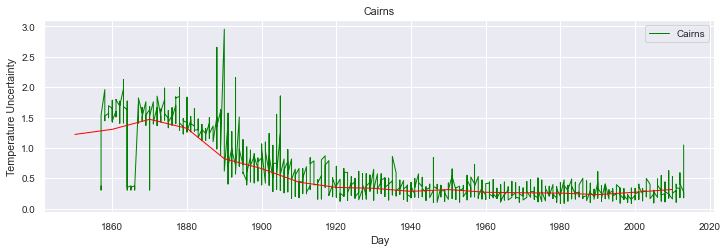

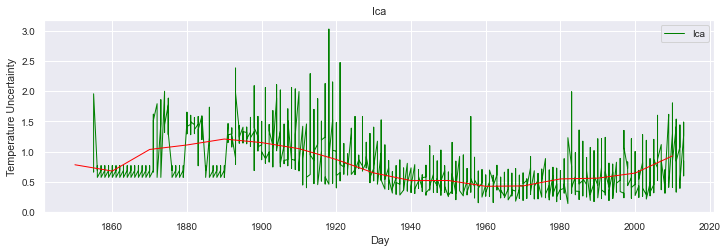

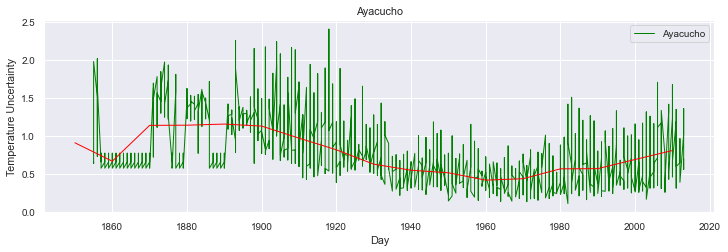

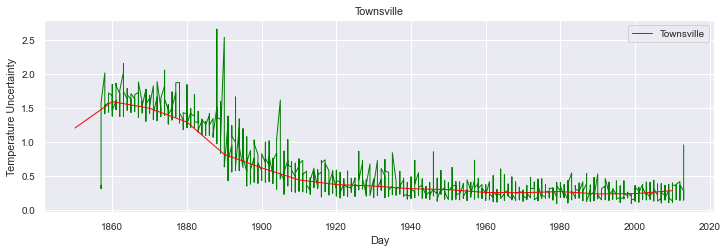

In [380]:
def plotting_TS_Averaged_tempUncertainty(df_fullData, df_AVG_data):
    for city in df_fullData.City.unique():
        

        df_fullData_City = df_fullData[df_fullData.City == city]
        df_AVG_data_City = df_AVG_data[df_AVG_data.City == city]
        
        plt.figure(figsize=(12,12))

        plt.subplot(3, 1, 1)
        plt.plot(df_fullData_City['year'], df_fullData_City['AverageTemperatureUncertainty'], color = 'green', linewidth=1, label = 'True value')
        plt.plot(df_AVG_data_City['DateTime'], df_AVG_data_City['AverageTemperatureUncertainty'], color = 'red', linewidth=1, label = 'Averaged value')

                
        plt.ylabel("Temperature Uncertainty")
        plt.xlabel("Day")
        plt.title(city)


        plt.rcParams.update({'figure.figsize': (10,10)})
        #plt.plot(df_AVG_data_City.DateTime, AveragedDecadal_DF_City.AverageTemperature, label = city)
        plt.legend(df_AVG_data_City.City.unique())
 
        

        

        
    return  

plotting_TS_Averaged_tempUncertainty(FullData_DF, AveragedDecadal_DF)

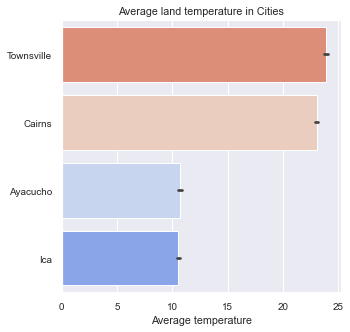

In [164]:
mean_temp_bar, countries_bar = (list(x) for x in zip(*sorted(zip(AveragedDecadal_DF.AverageTemperature, AveragedDecadal_DF.City), 
                                                             reverse = True)))
sns.set(font_scale=0.9) 
f, ax = plt.subplots(figsize=(5, 5))
colors_cw = sns.color_palette('coolwarm', len(AveragedDecadal_DF.City.unique()))
sns.barplot(mean_temp_bar, countries_bar, palette = colors_cw[::-1])
Text = ax.set(xlabel='Average temperature', title='Average land temperature in Cities')

In [240]:
##### LSTM #####
round((7568*0.30),0)

2270.0

In [317]:
##### LSTM #####
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt


,year,Country,City,month,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,DateTime
0,1857,Australia,Cairns,1,25.926096,0.373807,16.87S,145.67E,1857-01-01
1,1855,Peru,Ica,1,12.444333,0.690526,13.66S,75.14W,1855-01-01
2,1855,Peru,Ayacucho,1,11.202421,0.655386,13.66S,73.49W,1855-01-01
3,1857,Australia,Townsville,1,26.645316,0.362465,18.48S,147.04E,1857-01-01
4,1855,Peru,Ica,2,12.702939,0.760763,13.66S,75.14W,1855-02-01
...,...,...,...,...,...,...,...,...,...
7563,2013,Peru,Ica,6,8.513000,1.333000,13.66S,75.14W,2013-06-01
7564,2013,Peru,Ayacucho,7,8.976000,1.203000,13.66S,73.49W,2013-07-01
7565,2013,Peru,Ica,7,7.672000,1.332000,13.66S,75.14W,2013-07-01
7566,2013,Peru,Ica,8,8.705000,0.845000,13.66S,75.14W,2013-08-01


In [494]:
n_timestamp = 12 #predicting period (1 year)
n_epochs = 25
filter_on = 1

#
# Select model type
# 1: Single cell
# 2: Stacked
# 3: Bidirectional
model_type = 2

if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    
#



# Split data into n_timestamp
#
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)



In [495]:
# providing the forecast for each of 4 cities separatedly!
scaler = MinMaxScaler()
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min') # stopping the model run when the improving of the loss func stops within 2 itterations
loss = history.history['loss']
epochs = range(len(loss))


#l = round(len(FullData_DF_City)*0.30,0)
train=FullData_DF.iloc[:-2371].reset_index(drop=True)
test=FullData_DF.iloc[-2371:].reset_index(drop=True)
#print(train.shape,test.shape)

training_set = train.iloc[:, 4:5].values
training_set
testing_set = test.iloc[:, 4:5].values



### scalling data 
training_set_scaled = scaler.fit_transform(training_set)
testing_set_scaled = scaler.fit_transform(testing_set)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Training the model  
#
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)#, callbacks=[early_stopping])

# Get predicted data
#
y_predicted = model.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = scaler.inverse_transform(y_predicted)
y_train_descaled = scaler.inverse_transform(y_train)
y_test_descaled = scaler.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]


y_tested = y_test.ravel()




Epoch 1/25
163/163 [==============================] - 5s 14ms/step - loss: 0.1425
Epoch 2/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0909
Epoch 3/25
163/163 [==============================] - 2s 13ms/step - loss: 0.0911
Epoch 4/25
163/163 [==============================] - 2s 13ms/step - loss: 0.0907
Epoch 5/25
163/163 [==============================] - 2s 13ms/step - loss: 0.0868
Epoch 6/25
163/163 [==============================] - 2s 13ms/step - loss: 0.0849
Epoch 7/25
163/163 [==============================] - 2s 12ms/step - loss: 0.0825
Epoch 8/25
163/163 [==============================] - 2s 12ms/step - loss: 0.0773
Epoch 9/25
163/163 [==============================] - 2s 13ms/step - loss: 0.0761
Epoch 10/25
163/163 [==============================] - 4s 23ms/step - loss: 0.0712
Epoch 11/25
163/163 [==============================] - 3s 16ms/step - loss: 0.0679
Epoch 12/25
163/163 [==============================] - 2s 12ms/step - loss: 0.0664
Epoch 13/25
1

Text(0.5, 1.0, 'Predicted data')

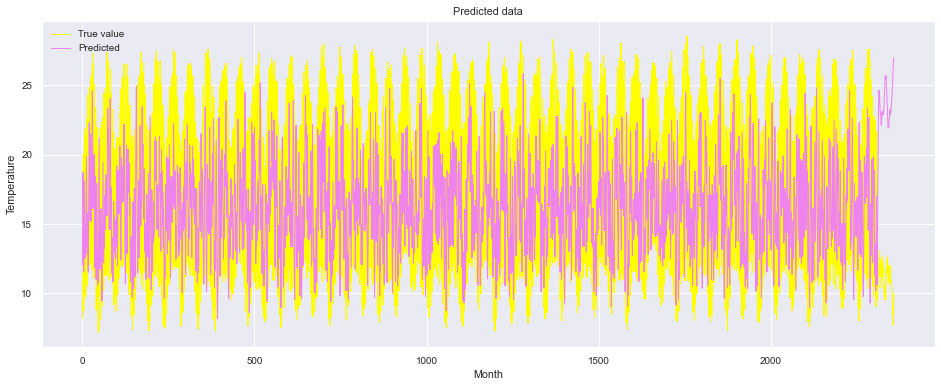

In [518]:

############### time series TESTED vs PREDICTED TEMP ##################
plt.figure(figsize=(16,6))
plt.plot(y_test_descaled,  color = 'yellow', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'violet',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Month")
plt.title("Predicted data")


In [532]:
y_predicted_descaled = scaler.inverse_transform(y_predicted)
y_predicted_descaled

y_train_descaled = scaler.inverse_transform(y_train)
y_test_descaled = scaler.inverse_transform(y_test)
y_test_descaled

y_pred = y_predicted.ravel() 
y_pred 

 

array([[11.78272053],
       [12.25587147],
       [23.76092016],
       ...,
       [11.92834801],
       [25.74033351],
       [23.6907144 ]])

In [535]:
########### PREDICTIVE MODELLING ##############
### AS Temparature baseline model, we will consider AveragedDecadal_DF with decadale averaged Temp #####
y_pred_Baseline= [y_train_descaled.mean()]*len(y_train_descaled)
print('Baseline MSE', round(mean_absolute_error(y_train, y_pred_Baseline),2))

Baseline MSE 16.9


In [536]:
# verification #
difference = y_test_descaled- y_predicted_descaled

print('RMSE', np.sqrt(np.mean(difference**2)))
print('MAE ', np.mean(abs(difference)))


RMSE 6.119357571384197
MAE  5.237650501744431
